<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
K-means Clustering and Principal Component Analysis
</h1><br>
Clustering and Principal Component Analysis are both techniques used for *unsupervised learning*. That means we would have unlabeled data and we are trying to find structure in the data that let us group similar examples together (clustering) or to have lower-dimensional representaion of the high dimensional data that would help us save memory and speed up learning algorithms as well as to be able to visualize it in 2D or 3D.

In the first part we'll implement the K-means algorithm and apply it on image compression. In the second part, we'll use Principal Component Analysis to find a low-dimensional representation of face images.

In [1]:
# import libraries
import numpy as np
from numpy.linalg import svd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from matplotlib.image import imread
import seaborn as sns

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Functions
</h2><br>
We'll write all the functions needed for both parts here.

In [2]:
# initialize centroids by assigning them to K training examples
def initializeCentroids(X, K):
    '''
    X: feature matrix m x n
    K: number of clusters
    Return: centroids vector K x n
    '''
    m = X.shape[0] # number of trainig examples
    # shuffle the index of the features without replacement
    random_index = np.random.permutation(m)
    
    return X[random_index[:K], :]

# calculate the squared distance between examples & all centroids and assign each
# example to the closest centroid
def findClosestCentroids(X, centroids):
    '''
    X: feature matrix m x n
    centroids: clusters' means k x n
    Return: index of examples' clusters m x 1
    '''
    m = X.shape[0]
    K = centroids.shape[0]
    # initialize distance matrix
    distance = np.zeros((m, K))
    
    for i in range(K):
        distance[:, i] = np.sum(np.square(X - centroids[i, :]), axis = 1)
    centroids = np.argmin(distance, axis = 1)

    return centroids

# calculate mean of each cluster (centroids)
def computeCentroids(X, idx, K):
    '''
    X: feature matrix m x n
    idx: index of examples' clusters
    K: number of clusters
    Return: centroids vector K x n
    '''
    n = X.shape[1]
    centroids = np.zeros((K, n))
    
    for i in range(K):
        centroids[i, :] = np.mean(X[idx == i, :], axis = 0)

    return centroids

# define kmean algorithm
def kMeans(X, K, maxiter = 10):
    '''
    X: feature matrix m x n
    K: number of clusters    
    maxiter: number of iterations the algorithm will go through 
    Return: centroids vector K x n and index vector m x 1
    '''
    # initializes centroids vector
    centroids = initializeCentroids(X, K)

    for i in range(maxiter):
        # assign examples to clusters
        idx = findClosestCentroids(X, centroids)
        # compute the mean of each cluster
        centroids = computeCentroids(X, idx, K)
        
    # rerun idx to get the latest assignment using final centroids vector
    idx = findClosestCentroids(X, centroids)
    
    return centroids, idx

# calculate k pca
def pca(X):
    '''
    X: feature matrix m x n
    Return: eigenvectors n x n and eigenvalues n x n
    '''
    m = X.shape[0]
    # compute covariance matrix
    cov_matrix = (1 / (m - 1)) * X.T.dot(X)
    # compute Singular Value Decomposition
    U, S, V = svd(cov_matrix)
    
    return U, S

# project data to k-dimension
def projectData(X, U, K):
    '''
    X: feature matrix m x n
    U: eigenvectors n x k
    K: new dimension --> scalar
    Return: projected feature matrix m x K
    '''
    Z = X.dot(U[:, :K])
    
    return Z

# recover data to its original dimension
def recoverData(Z, U, K):
    '''
    Z: projected feature matrix m x K
    U: eigenvectors n x k
    K: projected data dimension
    Return: recovered (approximated) feature matrix
    '''
    X_approx = Z.dot(U[:, :K].T)
    
    return X_approx

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
K-means Clustering
</h2><br>
K-means algorithm tries to partition dataset into $K$ distinct non-overlapping groups (clusters) where each example belongs to *only one group*. The way K-means algorithm works is as follows:
1. Specify number of clusters $K$.
2. Initialize centroids by first shuffle the dataset and then randomly selecting $K$ examples for the centroids without replacement.
3. Compute the squared euclidean distance between examples and all centroids.
4. Assign each example to the closest cluster (centroid).
5. Compute the centroids for the clusters by taking the average of the examples that belong to each cluster.
$$\frac{1}{C_k}\sum_{i \in C_k}x^i$$
where ${C_k}$ is the set of examples that are assigned to centroid $k$.
6. Recompute the distance between examples and all centroids and reassign each example to the closest cluster.
7. Keep iterating until there is no change to the centroids. i.e assignment of examples isn't changing.

The objective function is:
$$\frac{1}{m}\sum_{i = 1}^{m}\|x^i - \mu_{c^i}\|^2\\{}$$
where $\mu_{c^i}$ is the mean of the cluster the example $x^i$ belongs to.

Within-cluster variation is:
$$\frac{1}{m_k}\sum_{i = 1}^{m_k}\|x^i - \mu_{c^k}\|^2$$
The less variation we have within clusters, the more homogeneous (similar) the examples are within the same cluster. Note that different random initialization may lead to different clusters since K-means algorithm may *stuck in a local optimum and may not converge to global optimum*. Threfore, it's recommended that we iterate between 50-1000 over the algorithm and get the clusters that yield the lowest error. Moreover, there is no right answer in terms of the number of clusters that we should have in any problem. Since mostly we use clustering algorithms for some later/downstream purposes, we can evaluate how well the models are performing based on different $k$ clusters.

<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
K-means on 2D Dataset
</h2><br>
We'll first implement the K-means algorithm on 2D dataset and see how it works. The dataset has 300 examples and 2 features and we will try to find $k$ subgroups within those examples and group them accordingly. Therefore, we'll end with subgroups where each subgroup has examples that are more homogenous (similar) to each other than the rest of the examples.



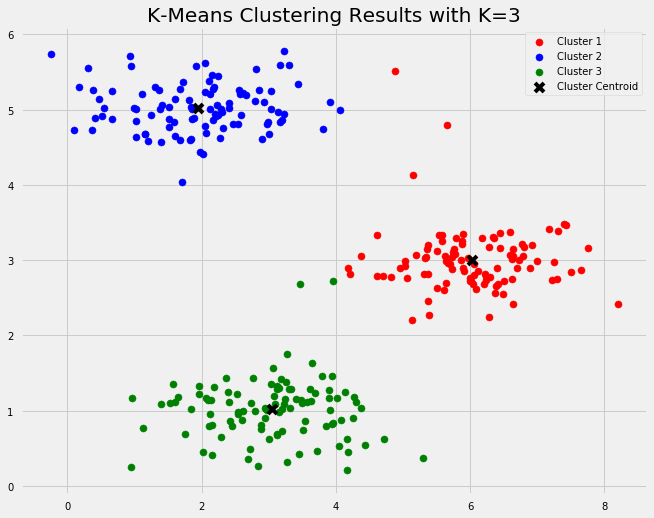

In [3]:
# load the data
data = loadmat('../data/ex7data2.mat')
X = data['X']
# set the number of clusters and iterations the Kmeans algorithm will go through
K = 3; maxiter = 10
# run the Kmeans algorithm and get the index of clusters for which each example
# belongs to as well as the final centroids vector
centroids, idx = kMeans(X, K, maxiter)
# plot the data colored by the clusters each example belongs to
fig, ax = plt.subplots(figsize = (10, 8))
plt.scatter(X[idx == 0, 0], X[idx == 0, 1], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(X[idx == 1, 0], X[idx == 1, 1], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(X[idx == 2, 0], X[idx == 2, 1], s = 50, c = 'green', label = 'Cluster 3')
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 80, c = 'k', label = 'Cluster Centroid')
plt.legend()
plt.title('K-Means Clustering Results with K=3');

The above graph shows the scatter plot of the examples colored by the cluster they belong to. In this example, we chose $K = 3$ and it seems it's not bad. The symbol **'x'** is the centroid of each cluster. One of the most common applications of K-means clustering is *Market Segmentation*. We can think of those 3 clusters as different kinds of customers that behave similarly or have similar purchasing patterns. Therefore, we can target those customers using different types of promotions or ads.

<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Image Compression with K-means
</h2><br>
In this exercise, we'll implement K-means to image compression. The image that we'll be working on is 128 x 128 x 3. Therefore, for each pixel location we would have 3 8-bit integers that specify the red, green, and blue intensity values. Our goal is to reduce the number of colors to 16 and represent (compress) the photo using those 16 colors only. To pick which colors to use, we'll use K-means algorithm on the image and treat every pixel as an example. That means we would have 128 x 128 = 16,384 examples. Doing so will allow us to represent the image using the 16 centroids for each pixel and would significantly reduce the size of the image by a factor of 6. The original image size was 128 x 128 x 24 = 393,216 bits; however, the new compressed image would be 16 x 24 + 128 x 128 x 4 = 65,920 bits. The huge difference comes from the fact that we'll be using centroids as a lookup for pixels' colors and that would reduce the size of each pixel location to 4-bit instead of 8-bit.

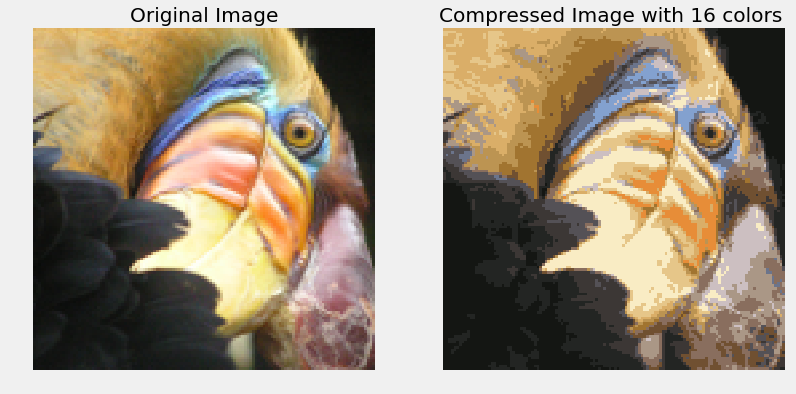

In [4]:
# read the image
A = imread('../images/bird_small.png')
# get the shape of the image
img_size = A.shape
# reshape it to be 2-dimension
X = A.reshape(img_size[0] * img_size[1], img_size[2])
# set the number of clusters and iterations the Kmeans algorithm will go through
K = 16; maxiter = 10
# run the Kmeans algorithm and get the index of clusters for which each example
# belongs to as well as the final centroids vector
centroids, idx = kMeans(X, K, maxiter)
# use the centroids colors as lookup for all examples
X_recovered = centroids[idx, :]
# reshape X_recovered to have the same dimension as the original image 128 * 128 * 3
X_recovered = X_recovered.reshape(img_size[0], img_size[1], img_size[2])
# plot the original and the compressed image next to each other
fig, ax = plt.subplots(1, 2, figsize = (12, 8))
ax[0].imshow(A)
ax[0].set_title('Original Image')
ax[1].imshow(X_recovered)
ax[1].set_title('Compressed Image with 16 colors ')
for ax in fig.axes:
    ax.axis('off');

We can see the comparison between the original image and the compressed one. The compressed looks very similar and close to the original one which means we're able to retain most of the characteristics of the original image.

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Principal Component Analysis (PCA)
</h2><br>
PCA is a dimensionality reduction technique that is used to compress data to speed up learning algorithms or to be able to visualize the data in 2D or 3D. Roughly speaking, it projects data from n-dimensional space into lower k-dimensional subspace with minimal loss of information. The higher the correlation between features $\rightarrow$ PCA allows us to summarize the data with lower principal components (directions) that explains most of the variation in the data. Note that PCA is not the same as linear regression in which it treats all features equally and don't look at the target variable and it computes error using perpendicular distance between the example and the projected data and **NOT** vertical line between the example and the straight line.

The way PCA works is as follows:
1. Normalize the feature to have mean 0
    * If the features are on a different scale, standarize to have standard deviation 1.
2. Compute the covariance matrix:
$$\sum = \frac{1}{m}X^TX\\{}$$
3. Compute eigenvectors and eigenvalues of the covariance matrix.
$$\sum V = U\Lambda$$
4. Pick the number of components that retains predetrmined % of variance.
$$1 - \frac{\sum_{i = 1}^{K}\lambda_{i}}{\sum_{i = 1}^{n}\lambda_{i}} \leq error$$
Eigenvectors are the principal components. They are orthonormal which means that they have length one and perpendicular to each other. We project the original data onto the direction of principal components.

Eigenvalues captures the % of variance explained by each eigenvector. Roughly speaking, eigenvalues are the magnitude or length of corresponding eigenvectors. If eigenvalues are around zero, they are less informative and may want to drop corresponding eigenvectors; however, if eigenvalues have high values, this means they capture a lot of the variation in th data and want to keep those eigenvectors. Note that if all eigenvalues are around the same values, this means that the data is already in a good space.The way to compute the variance captured by $K$ principal components:
$$\frac{\sum_{i = 1}^{K}\lambda_{i}}{\sum_{i = 1}^{n}\lambda_{i}}$$
where $\lambda_i$ is the eigenvalue for eigenvector $U^i$. Eigenvalues matrix is a diagonal matrix where everything off diagonal is zero.

Projected data:
$$Z = XU\\{}$$
Projected example:
$$Z^i = {x^i}^TU\\{}$$
Recovered data from projected:
$$X_{approx} = ZU^T\\{}$$
Also, the length of the projection from original data onto $u_1$ (first proncipal component) is $u_1^Tx^i$.
The higher the % of variance explained by principal components used $\rightarrow$ the less far off the recovered data from the original data.

<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
PCA on 2D Dataset
</h2><br>
In this exercise, we'll use principal component analysis (PCA) to perform
dimensionality reduction by reducing it from 2D to 1D. Therefore, we'll project the data onto real line. We have 50 examples and 2 features. We'll first normalize and scale the data before applying PCA. The graph below shows the direction of eigenvectors.

Eigenvalues are: [ 1.73553038  0.26446962]


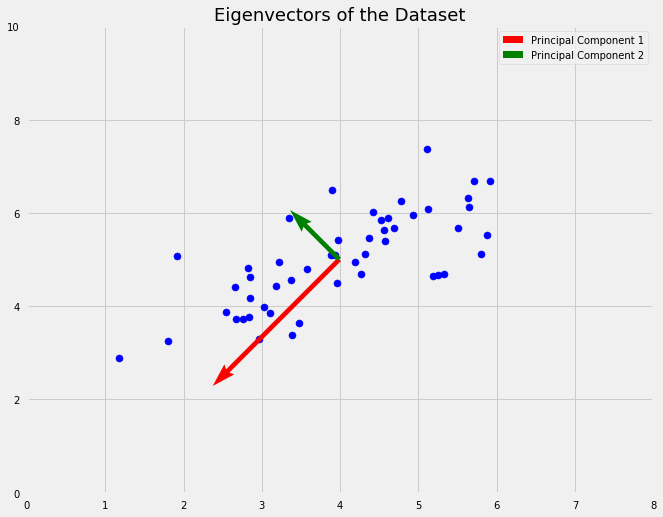

In [5]:
# load data
data = loadmat('../data/ex7data1.mat')
X = data['X']
# normalize the data to have mean 0 and std 1
X_mu = X.mean(axis = 0)
X_std = X.std(axis = 0, ddof = 1)
X_norm = (X - X_mu) / X_std
# compute eigenvectors and eigen values
U, S = pca(X_norm)
# project Data
X_proj = projectData(X_norm, U, 1)
# reconstructing original data from projected data
X_approx = recoverData(X_proj, U, 1)
# plot the principal components
fig, ax = plt.subplots(figsize = (10, 8))
plt.scatter(X[:, 0], X[:, 1], s = 50, c = 'blue')
plt.quiver(X_mu[0], X_mu[1], U[0, 0], U[1, 0], scale = 3.5, label = 'Principal Component 1', color = 'red')
plt.quiver(X_mu[0], X_mu[1], U[0, 1], U[1, 1], scale = 9, label = 'Principal Component 2', color = 'green')
plt.xlim([0, 8])
plt.ylim([0, 10])
plt.legend()
plt.title('Eigenvectors of the Dataset', fontsize = 18);
print('Eigenvalues are: {}'.format(S))

86.78% variance retained using the first component


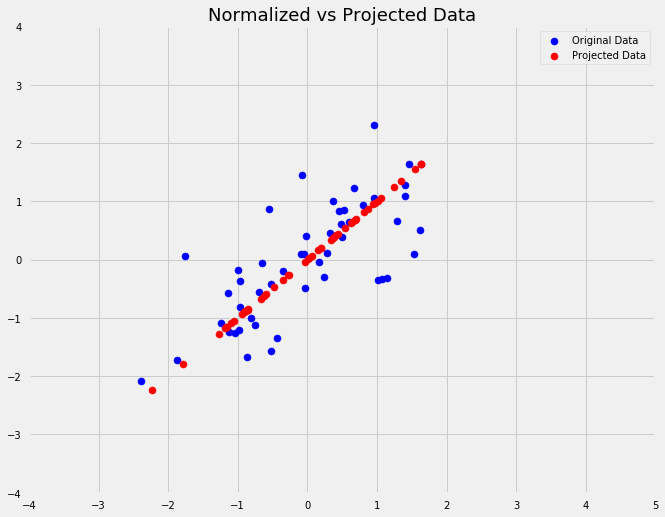

In [6]:
# plot original (normalized) vs projected data
fig, ax = plt.subplots(figsize = (10, 8))
plt.scatter(X_norm[:, 0], X_norm[:, 1], s = 50, c = 'blue', label = 'Original Data')
plt.scatter(X_approx[:, 0], X_approx[:, 1], s = 50, c = 'red', label = 'Projected Data')
plt.xlim([-4, 5])
plt.ylim([-4, 4])
plt.legend()
plt.title('Normalized vs Projected Data', fontsize = 18)
print('{:.2f}% variance retained using the first component'.format((S[0] / sum(S)) * 100));

The above graph shows original data vs projected data using the first component. The first component captures 86.78% of the variation in the data.

<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Image Compression with PCA
</h2><br>
In this exercise, We'll run PCA on 5000 face images where each image is 32 x 32 in grayscale. Therefore, our dataset is 5000 examples and 1,024 features. Below is a sample of 32 face images:

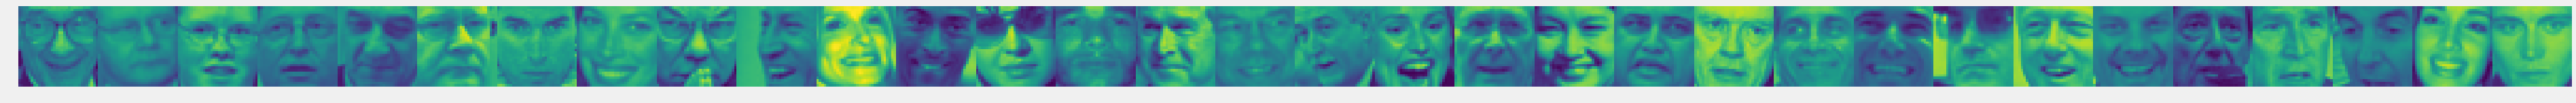

In [7]:
# load the face images data
data = loadmat('../data/ex7faces.mat')
X = data['X']
# plot the first 32 faces
fig, ax = plt.subplots(figsize = (60, 60))
plt.imshow(X[:32, :].reshape(-1, 32).T)
plt.axis('off');

Let's run the PCA and see how good the first 100 components will be in explaining the variation in the data:

In [8]:
# normalize the data
X_mu = X.mean(axis = 0)
X_std = X.std(axis = 0, ddof = 1)
X_norm = (X - X_mu) / X_std
# apply pca
U, S = pca(X_norm)
# compute the % of variation captured by the first 100 components
print('The first 100 components explain {:.2f}% of the variation'.format((np.sum(S[:100]) / S.sum()) * 100))

The first 100 components explain 93.19% of the variation


It looks like the first 100 components aren't bad at all in capturing the variation. Let's use those 100 components and try to compare images from projected data which now is compressed by a factor of 10 from 5000 x 1,024 to 5000 x 100.

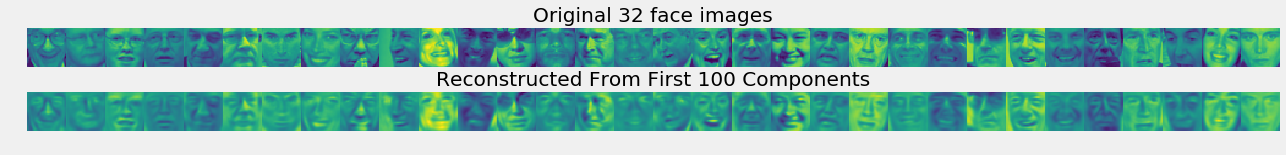

In [9]:
# project the data onto the top 100 eigenvectors
X_proj = projectData(X_norm, U, 100)
# reconstruct the data from 100 components
X_recovered = recoverData(X_proj, U, 100)
# plot the normalized reconstructed data
fig, ax = plt.subplots(2, 1, figsize = (20, 2))
ax[0].imshow(X[:32, :].reshape(-1, 32).T)
ax[0].set_title('Original 32 face images')
ax[1].imshow(X_recovered[:32, :].reshape(-1, 32).T)
ax[1].set_title('Reconstructed From First 100 Components')
for ax in fig.axes:
    ax.axis('off');

It looks like the compressed face images didn't loose much of information and are good to be used in downstream modeling.

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Conclusion
</h2><br>
* Normalize data before applying PCA
    * Scale it if the features are on different scales
* The most common % of variance retained when selecting $K$ components is 99%, 95%, 90%
* Adjacent pixels in images are highly correlated so we can represent data really well with smaller dimensions
* Apply learning algorithm on full original dataset and see what the results look like before applying PCA because we may not need to do it
* It's better to say that you selected $K$ principal components where x% of variance retained instead of saying I selected $K$ principal components
* Scale the data when applying K-means algorithm
* Elbow method in selecting number of clusters doesn't usually work because the error function is monotonically decreasing for all $k$s
* If there is no example assigned to a cluster, we should eliminate it
* K-means gives more weight to the bigger cluster
* K-means may still cluster the data even if it can't be clustered such as data that comes from *uniform distributions*. See below:

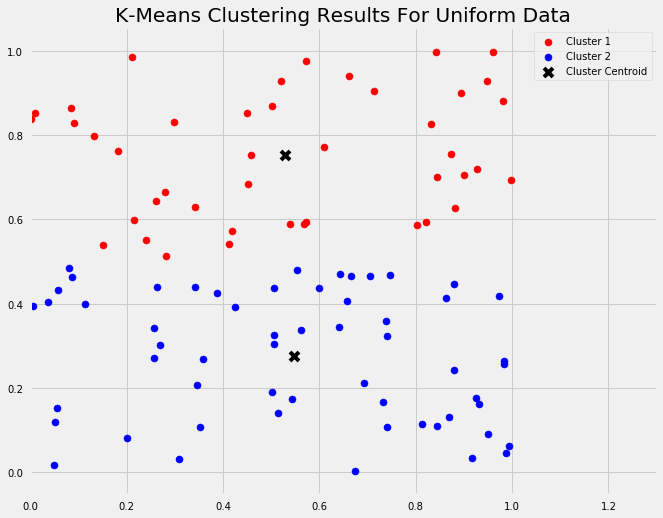

In [10]:
x1 = np.random.uniform(size = (100, 2))
k = 2
centroids, idx = kMeans(x1, k)
fig, ax = plt.subplots(figsize = (10, 8))
plt.scatter(x1[idx == 0, 0], x1[idx == 0, 1], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(x1[idx == 1, 0], x1[idx == 1, 1], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 80, c = 'k', label = 'Cluster Centroid')
plt.xlim([0, 1.3])
plt.legend(loc = 'upper right')
plt.title('K-Means Clustering Results For Uniform Data');